# Denoising by proximal solvers

We try to solve the following problem:

$$
arg \;  min_\mathbf{u} \frac{1}{2}||\mathbf{u-f}||_2^2 + \sigma J(\mathbf{u})
$$

with different choices of regularization:

- L2 on Gradient $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_2^2$
- L1 on Wavelet (Orthogonal operator) $ J(\mathbf{u}) = ||\mathbf{W} \mathbf{u}||_1$
- Anisotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1$
- Anisotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_1 - \mathbf{p}_k^T \mathbf{u}$
- Isotropic TV $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1}$
||\nabla \mathbf{u}||_{2,1}
- Isotropic TV + Bregman iterations $ J(\mathbf{u}) = ||\nabla \mathbf{u}||_{2,1} - \mathbf{p}_k^T \mathbf{u}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *

Data and operators preparation

In [2]:
# Load image
img = misc.ascent()
img = img/np.max(img)
ny, nx = img.shape

# Add noise
sigman = 0.2
n = sigman*np.max(abs(img.ravel()))*np.random.uniform(-1,1, img.shape)
#n = np.random.normal(0, sigman, img.shape)
noise_img = img + n

In [3]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

### L2 on Gradient

In [4]:
# L2 data term
l2 = L2(b=noise_img.ravel())

# L2 regularization
sigma = 2.
thik = L2(sigma=sigma)

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = 1. / (tau*L)

iml2 = LinearizedADMM(l2, thik, Gop, tau=tau, mu=mu, x0=np.zeros_like(img.ravel()), 
                      niter=100)[0]
iml2 = iml2.reshape(img.shape)

### L1 on Wavelet

In [5]:
# L2 data term
l2 = L2(b=noise_img.ravel())

# L1 Norm of Wavelet
sigma = .1
Qop = DWT2D(img.shape, wavelet='haar', level=4)
l1 = L1(sigma=sigma)
orth = Orthogonal(l1, Qop)

tau = 1. # eigs(Identity) as Identity is the operator of f

# This converges in one iteration
imq = ProximalGradient(l2, orth, x0=np.zeros_like(img.ravel()), tau=1., niter=1, show=True)
imq = imq.reshape(img.shape)

imq1 = ProximalGradient(l2, orth, x0=np.zeros_like(img.ravel()), tau=1., niter=5, show=True)
imq1 = imq1.reshape(img.shape)

print(np.allclose(imq, imq1))

Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Orthogonal.Orthogonal'>
tau = 1.000000e+00	beta=5.000000e-01
epsg = 1.000000e+00	niter = 1	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1   2.44197e-01   8.057e+02   1.658e+03   2.464e+03

Total time (s) = 0.04
---------------------------------------------------------

Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Orthogonal.Orthogonal'>
tau = 1.000000e+00	beta=5.000000e-01
epsg = 1.000000e+00	niter = 5	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1   2.44197e-01   8.057e+02   1.658e+03   2.464e+03
     2   2.44197e-01   8.057e+02   1.658e+03   2.464e+03
     3   2.44197e-01   8.057e+02   1.658e+03 

### Anisotropic TV

In [13]:
# L2 data term
l2 = L2(b=noise_img.ravel())

# Anisotropic TV
sigma = .1
l1 = L1(sigma=sigma)

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = tau / L

iml1 = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, x0=np.zeros_like(img.ravel()), 
                      niter=100, show=True)[0]
iml1 = iml1.reshape(img.shape)

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.250000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.47530e-02   1.735e+04   8.258e+02   1.817e+04
     2   4.36683e-02   1.405e+04   7.727e+02   1.482e+04
     3   7.79080e-02   1.155e+04   6.401e+02   1.219e+04
     4   1.05047e-01   9.586e+03   5.687e+02   1.015e+04
     5   1.28678e-01   8.007e+03   5.534e+02   8.560e+03
     6   1.50102e-01   6.739e+03   5.573e+02   7.297e+03
     7   1.69304e-01   5.725e+03   5.668e+02   6.292e+03
     8   1.86274e-01   4.916e+03   5.790e+02   5.495e+03
     9   2.01065e-01   4.271e+03   5.923e+02   4.863e+03
    10   2.13541e-01   3.758e+03   6.057e+02   4.364e+03
    11   2.24008e-01   3.351e+03   6.180e+02   3.969e+03
    21 

### Anisotropic TV + Bregman iterations

In [7]:
l1 = L1(sigma=sigma)
l1_ =  sigma * L1()

x = np.random.normal(0., 10., 10)
print(l1.prox(x, 2.)-l1_.prox(x, 2.))
print(l1.proxdual(x, 2.)-l1_.proxdual(x, 2.))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-3.60822483e-16  3.60822483e-16 -3.60822483e-16 -3.60822483e-16
 -3.60822483e-16 -8.32667268e-17 -8.32667268e-17  3.60822483e-16
  3.60822483e-16 -1.41553436e-15]


In [8]:
# L2 data term
sigma = 1.5
l2 = L2(b=noise_img.ravel())

# Anisotropic TV
l1 = L1()

L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = tau / L

iml1b = Bregman(l2, l1, x0=np.zeros_like(img.ravel()), A=Gop, 
                 solver=LinearizedADMM, alpha=sigma, niterouter=10, show=True,
                 **dict(tau=tau, mu=mu, niter=50))
iml1b = iml1b.reshape(img.shape)

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function LinearizedADMM at 0x7f91af7bf040>
alpha = 1.500000e+00	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   3.24765e-01   3.569e+03   2.542e+03   6.111e+03
     2   3.25748e-01   3.068e+03   3.779e+03   6.847e+03
     3   3.26882e-01   2.503e+03   5.934e+03   8.437e+03
     4   3.27881e-01   2.245e+03   7.557e+03   9.802e+03
     5   3.28707e-01   2.104e+03   8.642e+03   1.075e+04
     6   3.29410e-01   2.002e+03   9.586e+03   1.159e+04
     7   3.30051e-01   1.920e+03   1.052e+04   1.244e+04
     8   3.29210e-01   1.852e+03   1.143e+04   1.328e+04
     9   3.26633e-01   1.780e+03   1.248e+04   1.426e+04
    10   3.19323e-01   1.711e+03   1.366e+04   1

### Isotropic TV (with Primal-Dual)

In [9]:
# L2 data term
l2 = L2(b=noise_img.ravel())

# Isotropic TV
sigma= 0.1
l1iso = L21(ndim=2, sigma=sigma)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

iml12 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., x0=np.zeros_like(img.ravel()), 
                   niter=400, show=True)
iml12 = iml12.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 3.535534e-01	mu = 3.535534e-01
theta = 1.00		niter = 400

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   6.37130e-02   1.200e+04   1.512e+03   0.000e+00       1.351e+04
     2   1.10827e-01   7.059e+03   1.430e+03   0.000e+00       8.489e+03
     3   1.52051e-01   4.536e+03   1.175e+03   0.000e+00       5.711e+03
     4   1.88295e-01   3.218e+03   9.942e+02   0.000e+00       4.212e+03
     5   2.18165e-01   2.514e+03   8.974e+02   0.000e+00       3.411e+03
     6   2.41489e-01   2.129e+03   8.472e+02   0.000e+00       2.976e+03
     7   2.58952e-01   1.913e+03   8.174e+02   0.000e+00       2.731e+03
     8   2.71613e-01   1.789e+03   7

### Isotropic TV + Bregman iterations

In [10]:
sigma= 2.
l2 = L2(b=noise_img.ravel())

# Isotropic TV
l1iso = L21(ndim=2)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1 / np.sqrt(L)
mu = 1. / (tau*L)

iml12b = Bregman(l2, l1iso, x0=np.zeros_like(img.ravel()), 
                  solver=PrimalDual, A=Gop, alpha=sigma, 
                  niterouter=10, show=True,
                  **dict(tau=tau, mu=mu, theta=1., niter=50))
iml12b = iml12b.reshape(img.shape)

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function PrimalDual at 0x7f91af7bf1f0>
alpha = 2.000000e+00	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   3.21172e-01   3.175e+03   3.731e+03   6.906e+03
     2   3.17970e-01   2.979e+03   4.917e+03   7.895e+03
     3   3.15557e-01   2.692e+03   6.173e+03   8.864e+03
     4   3.13528e-01   2.372e+03   8.008e+03   1.038e+04
     5   3.11883e-01   2.194e+03   9.463e+03   1.166e+04
     6   3.10564e-01   2.087e+03   1.053e+04   1.262e+04
     7   3.09503e-01   2.007e+03   1.141e+04   1.342e+04
     8   3.08638e-01   1.938e+03   1.228e+04   1.422e+04
     9   3.07920e-01   1.871e+03   1.323e+04   1.510e+04
    10   3.07315e-01   1.805e+03   1.430e+04   1.6

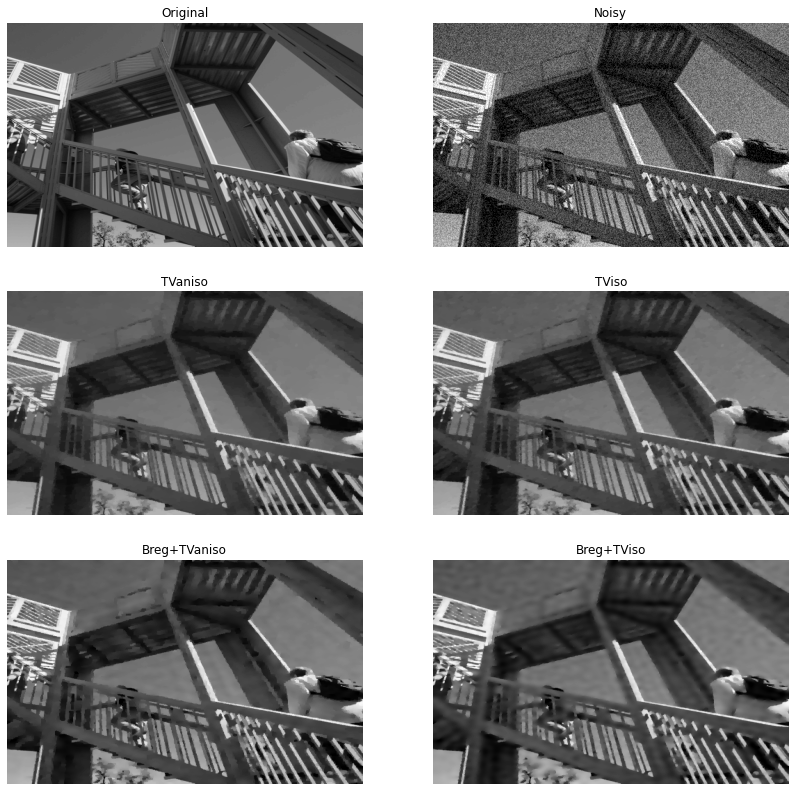

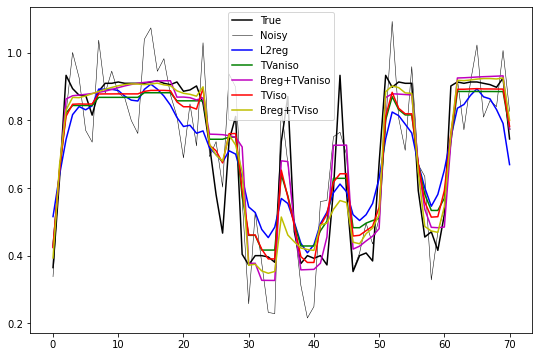

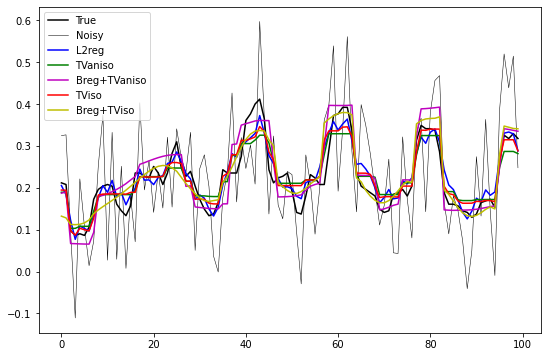

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
axs[0][0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml1, cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('TVaniso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12, cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');
axs[2][0].imshow(iml1b, cmap='gray', vmin=0, vmax=1)
axs[2][0].set_title('Breg+TVaniso')
axs[2][0].axis('off')
axs[2][0].axis('tight')
axs[2][1].imshow(iml12b, cmap='gray', vmin=0, vmax=1)
axs[2][1].set_title('Breg+TViso')
axs[2][1].axis('off')
axs[2][1].axis('tight')

ix_min = 84
ix_max = 155
iy = 20
plt.figure(figsize=(9, 6))
plt.plot(img[ix_min:ix_max, iy], 'k', label='True')
plt.plot(noise_img[ix_min:ix_max, iy], 'k', lw=0.5, label='Noisy')
plt.plot(iml2[ix_min:ix_max, iy], 'b', label='L2reg')
plt.plot(iml1[ix_min:ix_max, iy], 'g', label='TVaniso')
plt.plot(iml1b[ix_min:ix_max, iy], 'm', label='Breg+TVaniso')
plt.plot(iml12[ix_min:ix_max, iy], 'r', label='TViso')
plt.plot(iml12b[ix_min:ix_max, iy], 'y', label='Breg+TViso')
plt.legend();

ix = 50
iy_min = 250
iy_max = 350
plt.figure(figsize=(9, 6))
plt.plot(img[ix, iy_min:iy_max], 'k', label='True')
plt.plot(noise_img[ix, iy_min:iy_max], 'k', lw=0.5, label='Noisy')
plt.plot(iml2[ix, iy_min:iy_max], 'b', label='L2reg')
plt.plot(iml1[ix, iy_min:iy_max], 'g', label='TVaniso')
plt.plot(iml1b[ix, iy_min:iy_max], 'm', label='Breg+TVaniso')
plt.plot(iml12[ix, iy_min:iy_max], 'r', label='TViso')
plt.plot(iml12b[ix, iy_min:iy_max], 'y', label='Breg+TViso')
plt.legend();

## Salt and Pepper noise

At this point we have considered random noise. We will deal now with salt and pepper noise (which is 0 and 1 spikes added randomly to the image.

It turns out that in this case switching from a L2 norm to a L1 norm on the data term can be used to further improve our denoising capabilities:


$$
arg \;  min_\mathbf{u} ||\mathbf{u-f}||_1 + \sigma J(\mathbf{u})
$$

In [12]:
# Load image
img = misc.ascent()
#img = 2*img/np.max(img) - 1.
img = img/np.max(img)
ny, nx = img.shape

# Add salt and pepper noise
noiseperc = 0.1

isalt = np.random.permutation(np.arange(ny*nx))[:int(noiseperc*ny*nx)]
ipepper = np.random.permutation(np.arange(ny*nx))[:int(noiseperc*ny*nx)]
noise_img = img.copy().ravel()
noise_img[isalt] = img.max()
noise_img[ipepper] = img.min()
noise_img = noise_img.reshape(ny,nx)

In [13]:
# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')

### L2 data norm with Isotropic TV

In [14]:
# L2 data term
l2 = L2(b=noise_img.ravel())

# L1 regularization (isotropic TV)
sigma = .2
l1iso = L21(ndim=2, sigma=sigma)

# Primal-dual
L = 8. / sampling**2 # maxeig(Grad^H Grad)
tau = .1
mu = 1. / (tau*L)

iml12_l2 = PrimalDual(l2, l1iso, Gop, tau=tau, mu=mu, theta=1., x0=np.zeros_like(noise_img).ravel(), 
                      niter=400, show=True)
iml12_l2 = iml12_l2.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e-01	mu = 1.250000e+00
theta = 1.00		niter = 400

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   2.95900e-02   2.324e+04   1.470e+03   0.000e+00       2.472e+04
     2   4.97650e-02   2.018e+04   1.652e+03   0.000e+00       2.183e+04
     3   6.61798e-02   1.775e+04   1.606e+03   0.000e+00       1.936e+04
     4   8.43089e-02   1.577e+04   1.557e+03   0.000e+00       1.732e+04
     5   1.04440e-01   1.411e+04   1.541e+03   0.000e+00       1.566e+04
     6   1.25784e-01   1.274e+04   1.545e+03   0.000e+00       1.428e+04
     7   1.47258e-01   1.159e+04   1.561e+03   0.000e+00       1.315e+04
     8   1.67907e-01   1.062e+04   1

### L1 data norm with Isotropic TV

In [15]:
# L1 data term
l1 = L1(g=noise_img.ravel())

# L1 regularization (isotropic TV)
sigma = 0.7
l1iso = L21(ndim=2, sigma=sigma)

# Primal-dual
L =  8. / sampling**2 # maxeig(Grad^H Grad)
tau = 1.
mu = 1. / (tau*L)

iml12_l1 = PrimalDual(l1, l1iso, Gop, tau=tau, mu=mu, theta=1., 
                      x0=np.zeros_like(noise_img).ravel(), #x0=noise_img.ravel(), 
                      niter=100, show=True)
iml12_l1 = iml12_l1.reshape(img.shape)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.25490e-01   9.634e+04   5.661e+04   0.000e+00       1.529e+05
     2   3.25490e-01   9.634e+04   5.661e+04   0.000e+00       1.529e+05
     3   3.25490e-01   9.455e+04   5.120e+04   0.000e+00       1.458e+05
     4   3.25490e-01   9.033e+04   3.662e+04   0.000e+00       1.269e+05
     5   3.25490e-01   8.698e+04   2.692e+04   0.000e+00       1.139e+05
     6   3.25490e-01   8.569e+04   2.375e+04   0.000e+00       1.094e+05
     7   3.25490e-01   8.559e+04   2.111e+04   0.000e+00       1.067e+05
     8   3.25490e-01   8.663e+04   1

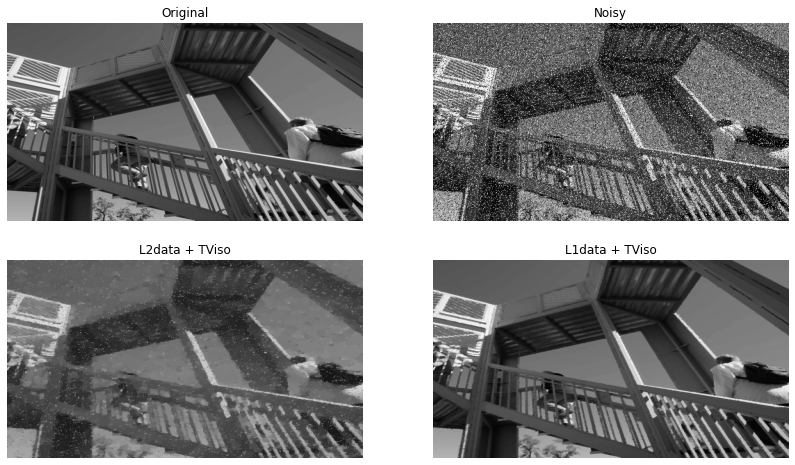

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0][0].imshow(img, cmap='gray', vmin=0, vmax=1)
axs[0][0].set_title('Original')
axs[0][0].axis('off')
axs[0][0].axis('tight')
axs[0][1].imshow(noise_img, cmap='gray', vmin=0, vmax=1)
axs[0][1].set_title('Noisy')
axs[0][1].axis('off')
axs[0][1].axis('tight')
axs[1][0].imshow(iml12_l2, cmap='gray', vmin=0, vmax=1)
axs[1][0].set_title('L2data + TViso')
axs[1][0].axis('off')
axs[1][0].axis('tight')
axs[1][1].imshow(iml12_l1, cmap='gray', vmin=0, vmax=1)
axs[1][1].set_title('L1data + TViso')
axs[1][1].axis('off')
axs[1][1].axis('tight');